In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


In [55]:
batch_size = 32
epochs = 50
learning_rate = .001
lambda_values = np.linspace(0, .1, 6)

In [56]:
n_per_cluster = 500
blur = 2.5

A = [1, 1]
B = [2, 10]
C = [9, 2]
D = [11, 10]

a = [A[0] + np.random.randn(n_per_cluster) * blur, A[1] + np.random.randn(n_per_cluster) * blur]
b = [B[0] + np.random.randn(n_per_cluster) * blur, B[1] + np.random.randn(n_per_cluster) * blur]
c = [C[0] + np.random.randn(n_per_cluster) * blur, C[1] + np.random.randn(n_per_cluster) * blur]
d = [D[0] + np.random.randn(n_per_cluster) * blur, D[1] + np.random.randn(n_per_cluster) * blur]

labels_np = np.vstack(
    (np.zeros((n_per_cluster, 1)),
     np.ones((n_per_cluster, 1)),
     np.full((n_per_cluster, 1), 2),
     np.full((n_per_cluster, 1), 3))
)

data_np = np.hstack((a, b, c, d)).T

data = torch.tensor(data_np).float()
labels = (torch.tensor(labels_np).long()).squeeze()

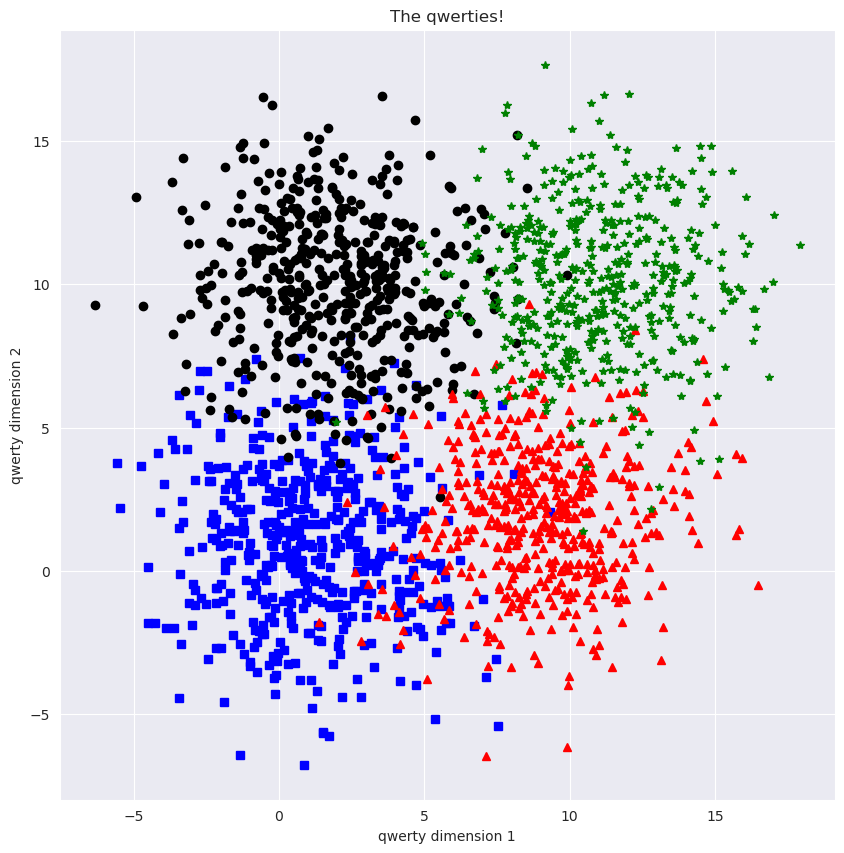

In [57]:
fig = plt.figure(figsize=(10, 10))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], "bs")
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], "ko")
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], "r^")
plt.plot(data[np.where(labels == 3)[0], 0], data[np.where(labels == 3)[0], 1], "g*")
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [58]:
def prepare_data():
    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2)

    train_data = TensorDataset(train_data, train_labels)
    test_data = TensorDataset(test_data, test_labels)

    train_loader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=False,
        drop_last=True
    )

    test_loader = DataLoader(
        test_data,
        batch_size=test_data.tensors[0].shape[0]
    )

    return train_loader, test_loader

In [59]:
class ClassifierModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(2, 8)
        self.fc1 = nn.Linear(8, 8)
        self.fc2 = nn.Linear(8, 8)
        self.output = nn.Linear(8, 4)

    def forward(self, x):
        x = f.relu(self.input(x))
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))

        return self.output(x)

In [60]:
def create_model(lambda_value):
    model = ClassifierModel()
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=lambda_value
    )

    return model, loss_func, optimizer

In [61]:
def create_and_train_model(train_loader, test_loader, lambda_value):
    model, loss_func, optimizer = create_model(lambda_value)
    model = model.to(device)
    loss_func = loss_func.to(device)

    losses = torch.zeros(epochs).to(device)
    train_acc = torch.zeros(epochs).to(device)
    test_acc = torch.zeros(epochs).to(device)

    for epoch in range(epochs):
        model.train()

        batches_quantity = len(train_loader)
        batch_acc = torch.zeros(batches_quantity).to(device)
        batch_losses = torch.zeros(batches_quantity).to(device)

        for batch_idx, (X, y) in enumerate(train_loader):
            X = X.to(device)
            y = y.to(device)

            preds = model(X)
            loss = loss_func(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses[batch_idx] = loss.item()

            matches = torch.argmax(preds, dim=1) == y
            matches_float = matches.float()
            accuracy = 100 * torch.mean(matches_float)
            batch_acc[batch_idx] = accuracy

        train_acc[epoch] = torch.mean(batch_acc)
        losses[epoch] = torch.mean(batch_losses)

        model.eval()
        X, y = next(iter(test_loader))
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad():
            preds = model(X)

        matches = torch.argmax(preds, dim=1) == y
        matches_float = matches.float()
        accuracy = 100 * torch.mean(matches_float)
        test_acc[epoch] = accuracy

    return train_acc, test_acc, losses, model

In [62]:
def compare_lambda_values():
    train_loader, test_loader = prepare_data()
    train_acc = torch.zeros(epochs, len(lambda_values)).to(device)
    test_acc = torch.zeros(epochs, len(lambda_values)).to(device)

    for lambda_idx, lambda_val in enumerate(lambda_values):
        lambda_train_acc, lambda_test_acc, losses, model = create_and_train_model(
            train_loader,
            test_loader,
            lambda_val
        )
        train_acc[:, lambda_idx] = lambda_train_acc
        test_acc[:, lambda_idx] = lambda_test_acc

    return train_acc, test_acc

In [63]:
train_acc, test_acc = compare_lambda_values()

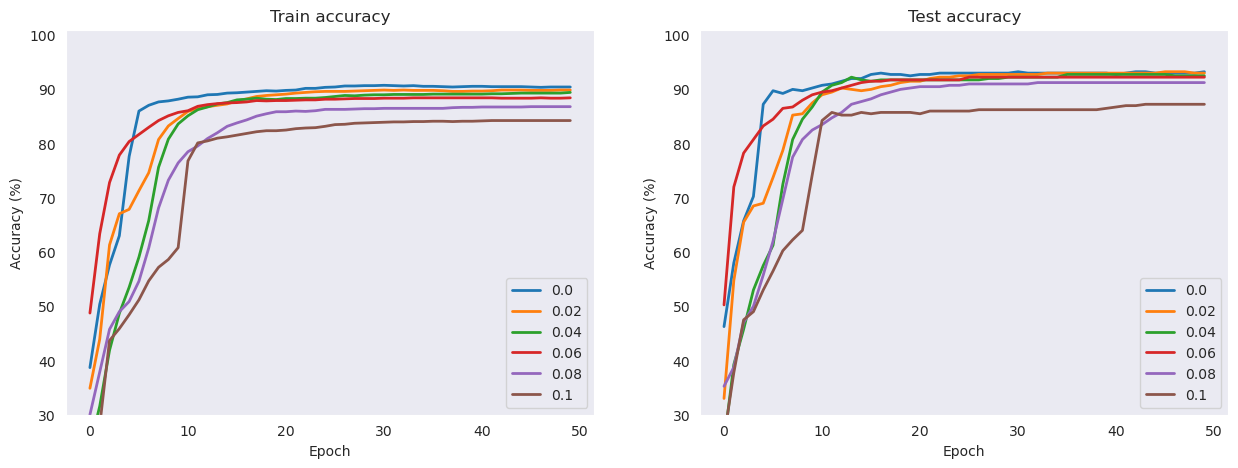

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(train_acc.to("cpu").numpy(), linewidth=2)
ax[0].set_title("Train accuracy")
ax[1].plot(test_acc.to("cpu").numpy(), linewidth=2)
ax[1].set_title("Test accuracy")

leg_labels = [np.round(i, 2) for i in lambda_values]

for i in range(2):
    ax[i].legend(leg_labels)
    ax[i].set_xlabel('Epoch')
    ax[i].set_ylabel('Accuracy (%)')
    ax[i].set_ylim([30, 101])
    ax[i].grid()

plt.show()